In [3]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import nltk
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns 
import json
import torch
import torch.nn as nn

In [4]:
cuda_available = torch.cuda.is_available()
print("CUDA Available:", cuda_available)
device = torch.device("cuda" if cuda_available else "cpu")

CUDA Available: True


In [5]:
# Ensure NLTK stopwords are downloaded
nltk.download('stopwords')

# Load English stopwords
stop_words = set(stopwords.words('english'))

# Load your data
df_train = pd.read_csv('/kaggle/input/assign4-nlp/train.csv')
df_test = pd.read_csv('/kaggle/input/assign4-nlp/test.csv')

def preprocess_text(text):
    text = text.lower()  # Lowercase the text
    # Remove punctuations
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Adding start of sequence and end of sequence tokens
    return f'<sos> {text} <eos>'

# Apply preprocessing
df_train['Processed'] = df_train['Description'].apply(preprocess_text)
df_test['Processed'] = df_test['Description'].apply(preprocess_text)
print(df_train.head())

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
   Class Index                                        Description  \
0            3  Reuters - Short-sellers, Wall Street's dwindli...   
1            3  Reuters - Private investment firm Carlyle Grou...   
2            3  Reuters - Soaring crude prices plus worries\ab...   
3            3  Reuters - Authorities have halted oil export\f...   
4            3  AFP - Tearaway world oil prices, toppling reco...   

                                           Processed  
0  <sos> reuters shortsellers wall streets dwindl...  
1  <sos> reuters private investment firm carlyle ...  
2  <sos> reuters soaring crude prices plus worrie...  
3  <sos> reuters authorities halted oil exportflo...  
4  <sos> afp tearaway world oil prices toppling r...  


In [6]:
def load_glove_embeddings(path, embedding_dim=100):
    embeddings_dict = {}
    with open(path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_dict[word] = vector
    return embeddings_dict

# Example path, adjust as necessary
glove_embeddings = load_glove_embeddings('/kaggle/input/assign4-nlp/glove.6B.100d.txt')


In [7]:
class ELMoLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, setting=1):
        super(ELMoLanguageModel, self).__init__()
        self.setting = setting
        self.forward_lstm1 = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        self.forward_lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers=1, batch_first=True)
        self.backward_lstm1 = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        self.backward_lstm2 = nn.LSTM(hidden_dim, hidden_dim, num_layers=1, batch_first=True)
        self.forward_pred = nn.Linear(hidden_dim, vocab_size)
        self.backward_pred = nn.Linear(hidden_dim, vocab_size)

        if setting == 1:
            self.gamma = nn.Parameter(torch.ones(3))
        elif setting == 2:
            self.gamma = torch.rand(3, requires_grad=False)
        elif setting == 3:
            self.combiner = nn.Sequential(
                nn.Linear(300, hidden_dim * 2),
                nn.ReLU(),
                nn.Linear(hidden_dim * 2, hidden_dim*2)
            )
            self.gamma = nn.Parameter(torch.ones(3))  # Still trainable but not directly used
        self.freeze_parameters()
        
    def freeze_parameters(self):
        for name, param in self.named_parameters():
            if 'gamma' and 'combiner' not in name:
                param.requires_grad = False
                
    def forward(self, x):
        forward_out1, _ = self.forward_lstm1(x)
        forward_out2, _ = self.forward_lstm2(forward_out1)
        reversed_embeddings = torch.flip(x, [1])
        backward_out1, _ = self.backward_lstm1(reversed_embeddings)
        backward_out2, _ = self.backward_lstm2(backward_out1)

        if self.setting in [1, 2]:
            combined_embeddings = self.gamma[0] * x + self.gamma[1] * torch.cat((forward_out1, backward_out1), dim=-1) + self.gamma[2] * torch.cat((forward_out2, backward_out2), dim=-1)
        elif self.setting == 3:
            combined_embeddings = self.combiner(torch.cat((x, forward_out1, backward_out1, forward_out2, backward_out2), dim=-1))
#             print(f"Combined Embeddings Shape (Setting 3): {combined_embeddings.shape}")
#             print(x.shape, forward_out1.shape, backward_out1.shape, forward_out2.shape, backward_out2.shape)

        forward_predictions = self.forward_pred(forward_out2)
        backward_predictions = self.backward_pred(torch.flip(backward_out2, [1]))
        return forward_predictions, backward_predictions, combined_embeddings
    
def load_model_and_mappings(model_path, mappings_path, mode=1):
    try:
        with open(mappings_path, 'rb') as f:
            token_to_index = pickle.load(f)
    except Exception as e:
        print(f"Failed to load token mappings: {e}")
        raise

    vocab_size = len(token_to_index)
    try:
        model = ELMoLanguageModel(vocab_size, embedding_dim=100, hidden_dim=50, setting=mode).to("cuda")
        model.load_state_dict(torch.load(model_path, map_location='cuda'))
    except Exception as e:
        print(f"Failed to load model with settings from {model_path}: {e}")
        raise

    return model, token_to_index


import pickle
model_path = '/kaggle/input/assign4-nlp/elmo_model_state_dict.pth'
mappings_path = '/kaggle/input/assign4-nlp/token_to_index.pkl'
model_path2 = '/kaggle/input/assign4-nlp/elmo_model_state_dict_2.pth'
model_path3 = '/kaggle/input/assign4-nlp/elmo_model_state_dict_3.pth'

In [8]:
elmo_model, token_to_index = load_model_and_mappings(model_path, mappings_path, mode=1)
print("Model 1 Loaded with settings for mode 1.")

elmo_model_2, _ = load_model_and_mappings(model_path2, mappings_path, mode=2)
print("Model 2 Loaded with settings for mode 2.")

elmo_model_3, _ = load_model_and_mappings(model_path3, mappings_path, mode=3)
print("Model 3 Loaded with settings for mode 3.")

Model 1 Loaded with settings for mode 1.
Model 2 Loaded with settings for mode 2.
Model 3 Loaded with settings for mode 3.


In [9]:
texts_train = df_train['Processed'].tolist()
texts_test = df_test['Processed'].tolist()
# texts_val = val_df_preprocessed['text'].tolist()
labels_train = df_train['Class Index'].tolist()
labels_test = df_test['Class Index'].tolist()
# labels_val = val_df_preprocessed['label'].tolist()

In [10]:
class DatasetCreate(Dataset):
    def __init__(self, texts, labels, glove_embeddings, token_to_index):
        self.texts = texts
        self.labels = labels
        self.token_to_index = token_to_index

        # Normalize labels
        self.label_encoder = LabelEncoder()
        self.labels = self.label_encoder.fit_transform(labels)

    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        tokens = text.split()
        embeddings = [glove_embeddings.get(token, np.zeros(100)) for token in tokens]
        input_embeddings = torch.tensor(embeddings, dtype=torch.float)
        target_label = torch.tensor(label, dtype=torch.long)
        return input_embeddings, target_label

    def get_label_encoder(self):
        return self.label_encoder

def collate_fn(batch):
    inputs, labels = zip(*batch)
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0.0)
    labels = torch.tensor(labels, dtype=torch.long)
    return inputs_padded, labels

In [11]:
# BiLSTM Classifier Definition
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=1, dropout=0.5):
        super(BiLSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # Multiply by 2 for bidirectional output

    def forward(self, x):
#         print(f"Input shape to LSTM: {x.shape}")
        lstm_out, _ = self.lstm(x)
        last_outputs = lstm_out[:, -1, :]  # Get the last time step output
        output = self.fc(last_outputs)
#         print(output.shape)
        return output
    
num_classes = len(set(df_train['Class Index']))
classifier = BiLSTMClassifier(input_dim=100, hidden_dim=100, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(elmo_model.parameters()) + list(classifier.parameters()), lr=0.001)

train_dataset = DatasetCreate(texts_train, labels_train, glove_embeddings, token_to_index)
test_dataset = DatasetCreate(texts_test, labels_test, glove_embeddings, token_to_index)

# Load data into DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [12]:
def train_task(num_epochs,elmo_model,optimizer):
    for epoch in range(num_epochs):
        elmo_model.train()
        classifier.train()
        total_loss = 0

        for input_data, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            input_data, labels = input_data.to(device), labels.to(device)
            optimizer.zero_grad()

            # Generate embeddings using ELMo
            _, _, embeddings = elmo_model(input_data)

            # Pass embeddings to the BiLSTM classifier
            outputs = classifier(embeddings)
#             print(labels.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Average Loss Epoch {epoch+1}: {total_loss / len(train_loader)}")

In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns  # for a nicer confusion matrix visualization

def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, xticklabels=class_names, yticklabels=class_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

def extract_features(dataloader, elmo_model, classifier, device):
    elmo_model.eval()
    classifier.eval()
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for input_data, labels in tqdm(dataloader):
            input_data = input_data.to(device)
            # Generate embeddings using ELMo
            _, _, embeddings = elmo_model(input_data)
            outputs = classifier(embeddings)
            all_embeddings.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_embeddings), np.array(all_labels)

## Static lambas

Epoch 1/10:   0%|          | 0/3750 [00:00<?, ?it/s]/tmp/ipykernel_33/1353582945.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  input_embeddings = torch.tensor(embeddings, dtype=torch.float)
Epoch 1/10: 100%|██████████| 3750/3750 [02:17<00:00, 27.34it/s]


Average Loss Epoch 1: 0.37003686499297617


Epoch 2/10: 100%|██████████| 3750/3750 [02:15<00:00, 27.70it/s]


Average Loss Epoch 2: 0.2974380841175715


Epoch 3/10: 100%|██████████| 3750/3750 [02:15<00:00, 27.76it/s]


Average Loss Epoch 3: 0.27447683651447297


Epoch 4/10: 100%|██████████| 3750/3750 [02:15<00:00, 27.60it/s]


Average Loss Epoch 4: 0.2577085072030624


Epoch 5/10: 100%|██████████| 3750/3750 [02:15<00:00, 27.62it/s]


Average Loss Epoch 5: 0.24455696320931117


Epoch 6/10: 100%|██████████| 3750/3750 [02:15<00:00, 27.72it/s]


Average Loss Epoch 6: 0.23224739218602578


Epoch 7/10: 100%|██████████| 3750/3750 [02:15<00:00, 27.76it/s]


Average Loss Epoch 7: 0.22080902346471945


Epoch 8/10: 100%|██████████| 3750/3750 [02:14<00:00, 27.85it/s]


Average Loss Epoch 8: 0.2107708943227927


Epoch 9/10: 100%|██████████| 3750/3750 [02:15<00:00, 27.59it/s]


Average Loss Epoch 9: 0.20120072319110235


Epoch 10/10: 100%|██████████| 3750/3750 [02:15<00:00, 27.61it/s]


Average Loss Epoch 10: 0.19169897083143395


100%|██████████| 238/238 [00:08<00:00, 28.87it/s]


Confusion Matrix Model_1 Test Set:
 [[1700   45   82   73]
 [  24 1845   18   13]
 [  53   16 1624  207]
 [  46   17  130 1707]]


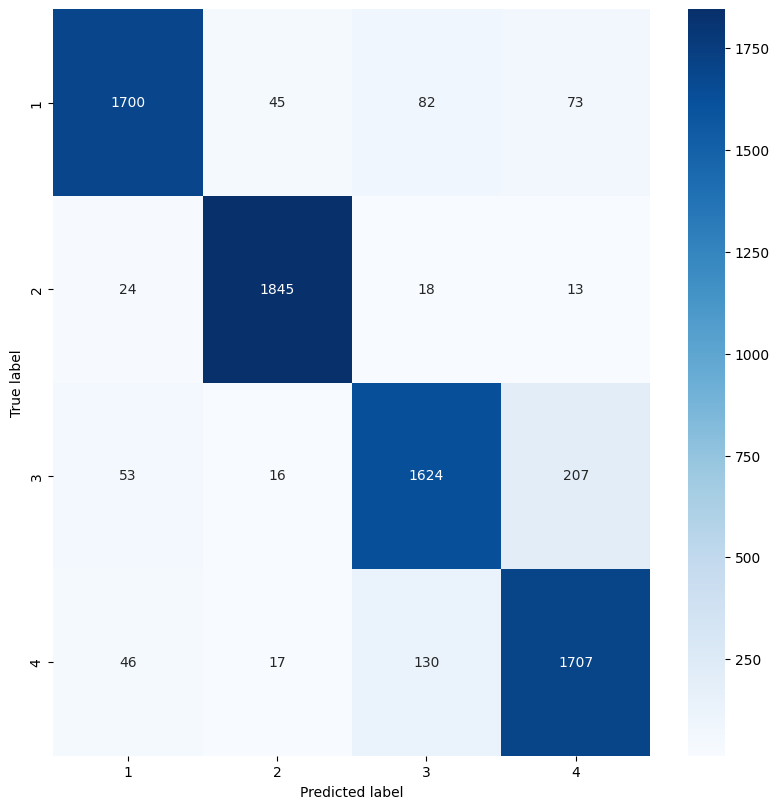

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1900
           1       0.96      0.97      0.97      1900
           2       0.88      0.85      0.87      1900
           3       0.85      0.90      0.88      1900

    accuracy                           0.90      7600
   macro avg       0.91      0.90      0.90      7600
weighted avg       0.91      0.90      0.90      7600



In [11]:
train_task(10,elmo_model,optimizer)

test_embeddings, test_labels = extract_features(test_loader, elmo_model, classifier, device)

predicted_labels = np.argmax(test_embeddings, axis=1)
# Generate confusion matrix

cm = confusion_matrix(test_labels, predicted_labels)
print("Confusion Matrix Model_1 Test Set:\n", cm)

class_names = ['1', '2', '3','4']  
fig = plot_confusion_matrix(cm, class_names)
plt.show()
print(classification_report(test_labels, predicted_labels))

## Training and Confusion Matrix using Trainable lambdas

Epoch 1/10:   0%|          | 0/3750 [00:00<?, ?it/s]/tmp/ipykernel_34/3397775139.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  input_embeddings = torch.tensor(embeddings, dtype=torch.float)
Epoch 1/10: 100%|██████████| 3750/3750 [02:14<00:00, 27.85it/s]


Average Loss Epoch 1: 0.3796518965194623


Epoch 2/10: 100%|██████████| 3750/3750 [02:14<00:00, 27.92it/s]


Average Loss Epoch 2: 0.32021739404002825


Epoch 3/10: 100%|██████████| 3750/3750 [02:14<00:00, 27.89it/s]


Average Loss Epoch 3: 0.301413805137078


Epoch 4/10: 100%|██████████| 3750/3750 [02:13<00:00, 28.01it/s]


Average Loss Epoch 4: 0.2873771372511983


Epoch 5/10: 100%|██████████| 3750/3750 [02:14<00:00, 27.90it/s]


Average Loss Epoch 5: 0.27604261763791244


Epoch 6/10: 100%|██████████| 3750/3750 [02:12<00:00, 28.22it/s]


Average Loss Epoch 6: 0.2662141867031654


Epoch 7/10: 100%|██████████| 3750/3750 [02:13<00:00, 28.05it/s]


Average Loss Epoch 7: 0.2567017406801383


Epoch 8/10: 100%|██████████| 3750/3750 [02:14<00:00, 27.88it/s]


Average Loss Epoch 8: 0.24929418353835742


Epoch 9/10: 100%|██████████| 3750/3750 [02:14<00:00, 27.98it/s]


Average Loss Epoch 9: 0.24144548342178265


Epoch 10/10: 100%|██████████| 3750/3750 [02:14<00:00, 27.98it/s]


Average Loss Epoch 10: 0.2331864022254944


100%|██████████| 238/238 [00:08<00:00, 29.47it/s]


Confusion Matrix Model_2 Test Set:
 [[1709   38   82   71]
 [  19 1840   16   25]
 [  61   16 1622  201]
 [  50   15  124 1711]]


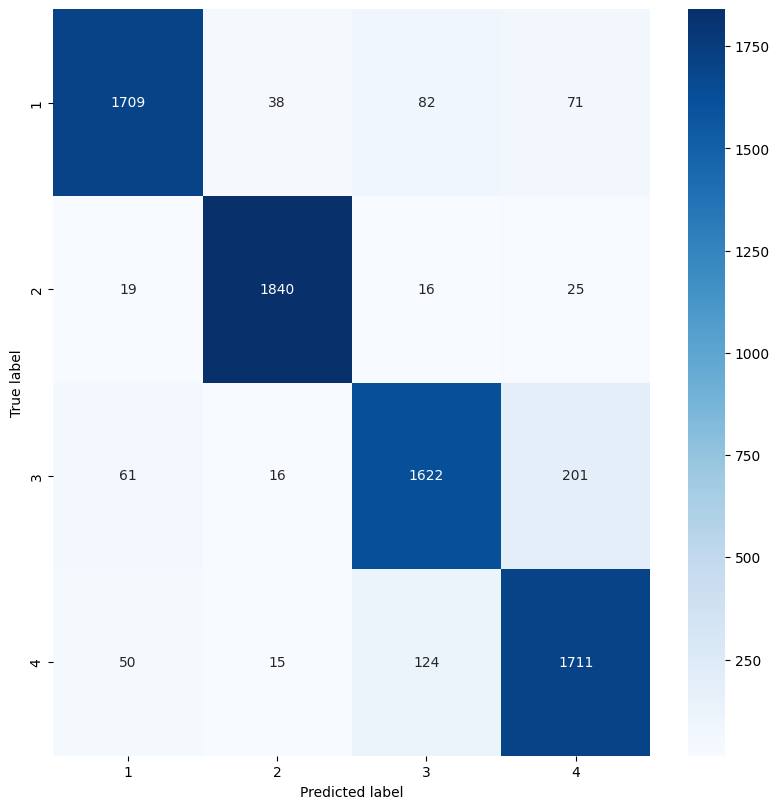

              precision    recall  f1-score   support

           0       0.93      0.90      0.91      1900
           1       0.96      0.97      0.97      1900
           2       0.88      0.85      0.87      1900
           3       0.85      0.90      0.88      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(elmo_model_2.parameters()) + list(classifier.parameters()), lr=0.001)

train_task(10,elmo_model_2,optimizer)

test_embeddings, test_labels = extract_features(test_loader, elmo_model_2, classifier, device)

predicted_labels = np.argmax(test_embeddings, axis=1)
# Generate confusion matrix

cm = confusion_matrix(test_labels, predicted_labels)
print("Confusion Matrix Model_2 Test Set:\n", cm)

class_names = ['1', '2', '3','4'] 
fig = plot_confusion_matrix(cm, class_names)
plt.show()
print(classification_report(test_labels, predicted_labels))

## Training and Confusion Matrix using learnable function

Epoch 1/10: 100%|██████████| 3750/3750 [02:15<00:00, 27.73it/s]


Average Loss Epoch 1: 0.39976064515312515


Epoch 2/10: 100%|██████████| 3750/3750 [02:15<00:00, 27.70it/s]


Average Loss Epoch 2: 0.2941606660803159


Epoch 3/10: 100%|██████████| 3750/3750 [02:16<00:00, 27.52it/s]


Average Loss Epoch 3: 0.2710316432595253


Epoch 4/10: 100%|██████████| 3750/3750 [02:15<00:00, 27.70it/s]


Average Loss Epoch 4: 0.25626359567344187


Epoch 5/10: 100%|██████████| 3750/3750 [02:14<00:00, 27.78it/s]


Average Loss Epoch 5: 0.24569804172466198


Epoch 6/10: 100%|██████████| 3750/3750 [02:15<00:00, 27.74it/s]


Average Loss Epoch 6: 0.2357996842339635


Epoch 7/10: 100%|██████████| 3750/3750 [02:15<00:00, 27.60it/s]


Average Loss Epoch 7: 0.22920218399514755


Epoch 8/10: 100%|██████████| 3750/3750 [02:15<00:00, 27.63it/s]


Average Loss Epoch 8: 0.22326067497382562


Epoch 9/10: 100%|██████████| 3750/3750 [02:16<00:00, 27.49it/s]


Average Loss Epoch 9: 0.21934640725453694


Epoch 10/10: 100%|██████████| 3750/3750 [02:15<00:00, 27.72it/s]


Average Loss Epoch 10: 0.21378232757995527


100%|██████████| 238/238 [00:08<00:00, 28.83it/s]


Confusion Matrix Model_3 Test Set:
 [[1705   51   68   76]
 [  17 1851   15   17]
 [  51   18 1613  218]
 [  45   13  108 1734]]


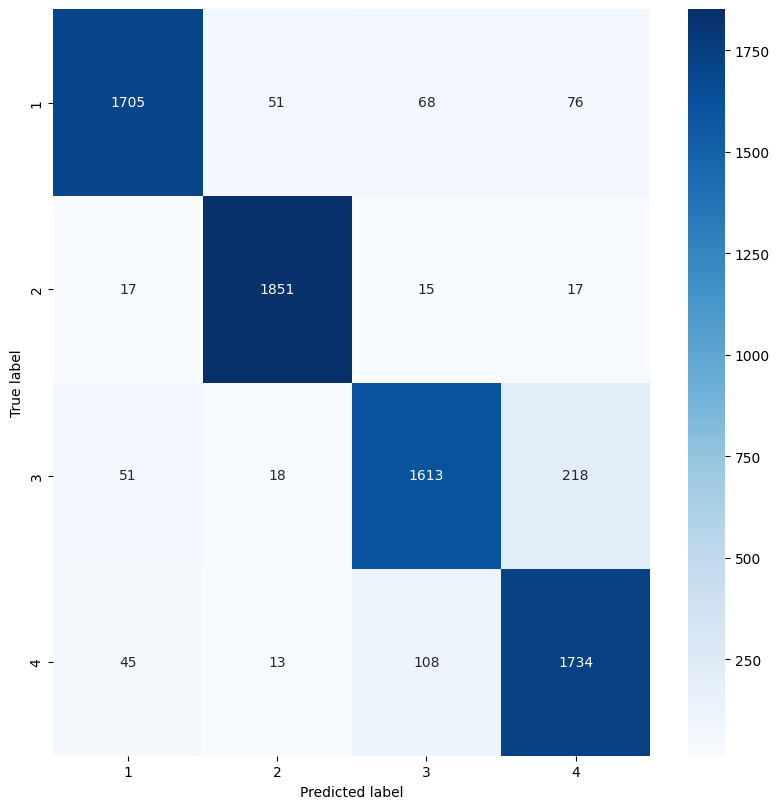

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1900
           1       0.96      0.97      0.97      1900
           2       0.89      0.85      0.87      1900
           3       0.85      0.91      0.88      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(list(elmo_model_3.parameters()) + list(classifier.parameters()), lr=0.001)

train_task(10,elmo_model_3,optimizer)

test_embeddings, test_labels = extract_features(test_loader, elmo_model_3, classifier, device)

predicted_labels = np.argmax(test_embeddings, axis=1)
# Generate confusion matrix

cm = confusion_matrix(test_labels, predicted_labels)
print("Confusion Matrix Model_3 Test Set:\n", cm)

class_names = ['1', '2', '3','4'] 
fig = plot_confusion_matrix(cm, class_names)
plt.show()
print(classification_report(test_labels, predicted_labels))